In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

from pytorch_lightning.loggers import CSVLogger

from estimator import XformerEstimator

In [4]:
dataset = get_dataset("exchange_rate")

In [5]:
estimator = XformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[3],
    
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        hidden_layer_multiplier=1,
        activation="gelu",

#         # longformer
#         attention_args={"name": "global",},
#         reversible=True, 
        
        # favor/performer
        attention_args={"name": "favor", "iter_before_redraw": 2},
    
        scaling=True,
        batch_size=256,
        num_batches_per_epoch=200,
        #distr_output=ImplicitQuantileNetworkOutput("positive"),
        #loss=QuantileLoss(),
        trainer_kwargs=dict(gpus="1", max_epochs=30, logger=CSVLogger(".", "lightning_logs/")),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached -2.39553 (best -2.39553), saving model to './lightning_logs/version_7/checkpoints/epoch=0-step=200.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached -2.64429 (best -2.64429), saving model to './lightning_logs/version_7/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' was not in top 1
Epoch 3, global step 800: 'train_loss' reached -2.73290 (best -2.73290), saving model to './lightning_logs/version_7/checkpoints/epoch=3-step=800.ckpt' as top 1
Epoch 4, global step 1000: 'train_loss' reached -2.94340 (best -2.94340), saving model to './lightning_logs/version_7/checkpoints/epoch=4-step=1000.ckpt' as top 1
Epoch 5, global step 1200: 'train_loss' reached -2.98574 (best -2.98574), saving model to './lightning_logs/version_7/checkpoints/epoch=5-step=1200.ckpt' as top 1
Epoch 6, global step 1400: 'train_loss' reached -3.14744 (best -3.14744), saving model to './lightning_logs/version_7/checkpoints/epoch

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 40it [00:00, 74.56it/s]


In [12]:
agg_metrics

{'MSE': 0.005701744938111234,
 'abs_error': 68.61437417939305,
 'abs_target_sum': 975.9766580164433,
 'abs_target_mean': 0.8133138816803693,
 'seasonal_error': 0.006515919403041842,
 'MASE': 8.963247523737747,
 'MAPE': 0.0699259030725807,
 'sMAPE': 0.06655537533263366,
 'MSIS': 206.49225239258152,
 'QuantileLoss[0.1]': 86.57541626133025,
 'Coverage[0.1]': 0.865,
 'QuantileLoss[0.2]': 87.95176725685596,
 'Coverage[0.2]': 0.8733333333333334,
 'QuantileLoss[0.3]': 84.04697430413216,
 'Coverage[0.3]': 0.8866666666666667,
 'QuantileLoss[0.4]': 77.30092919878662,
 'Coverage[0.4]': 0.9091666666666667,
 'QuantileLoss[0.5]': 68.61437537427992,
 'Coverage[0.5]': 0.9316666666666666,
 'QuantileLoss[0.6]': 57.978374324738986,
 'Coverage[0.6]': 0.9533333333333334,
 'QuantileLoss[0.7]': 46.30905397608877,
 'Coverage[0.7]': 0.9758333333333333,
 'QuantileLoss[0.8]': 33.131346242129794,
 'Coverage[0.8]': 0.9949999999999999,
 'QuantileLoss[0.9]': 18.169621344842014,
 'Coverage[0.9]': 1.0,
 'RMSE': 0.0755

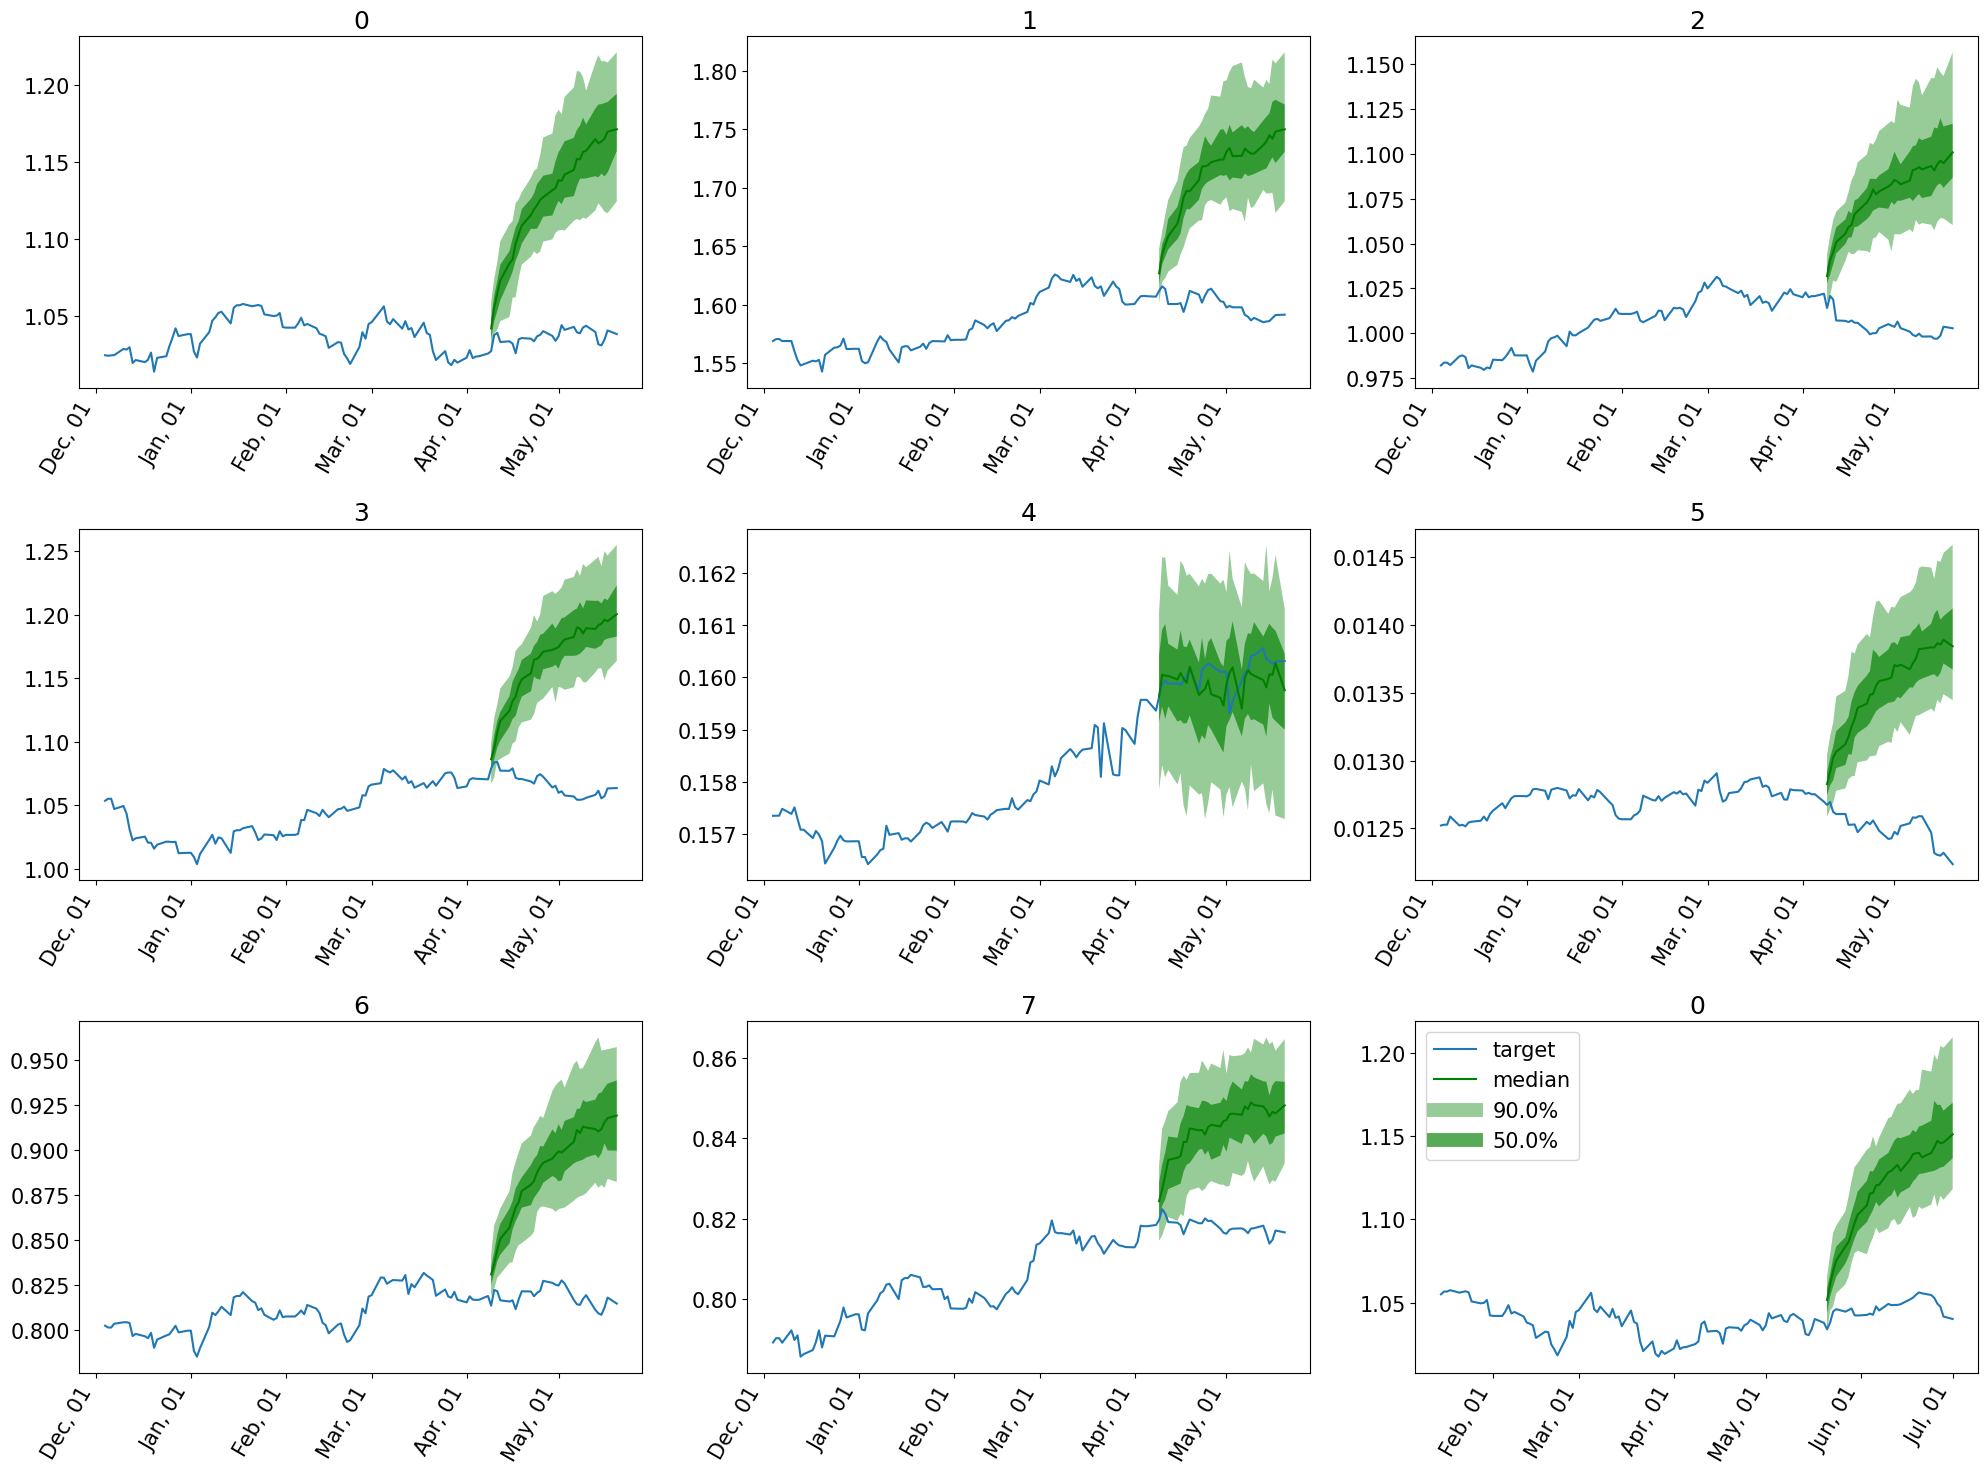

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [36]:
metrics = pd.read_csv("lightning_logs/version_34/metrics.csv")

In [37]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,1.077298,0,49,NaN,NaN
1,1.052201,0,99,NaN,NaN
2,NaN,0,99,-3.059156,NaN
3,NaN,0,99,NaN,-1.421714
4,1.064031,1,149,NaN,NaN
...,...,...,...,...,...
395,NaN,98,9899,NaN,-4.208968
396,27.830784,99,9949,NaN,NaN
397,26.394091,99,9999,NaN,NaN
398,NaN,99,9999,-4.432779,NaN


Text(0, 0.5, 'perplexity')

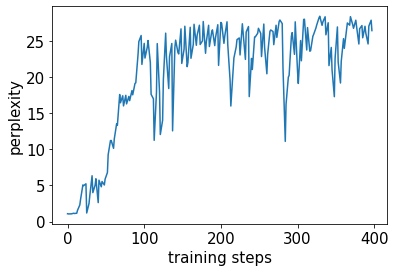

In [38]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

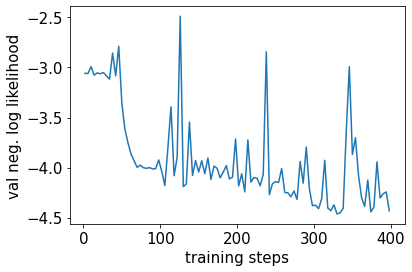

In [39]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [16]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [17]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

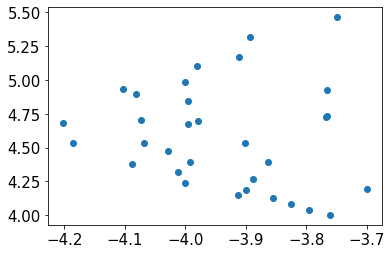

In [18]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)